<a href="https://colab.research.google.com/github/nguyenvuong1309/Do-an-lap-trinh-an-toan/blob/main/BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import pandas as pd
from numpy import zeros, newaxis
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional,Activation
import matplotlib.pyplot as plt
import csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
csv_file_path = '/content/drive/MyDrive/Colab/dataset/text_dataset.csv'
df = pd.read_csv(csv_file_path,sep=",")

In [ ]:
dataset = df

In [ ]:
print(dataset.head())

   Index                                                  1  label
0      0  1 150200/dirent_uri.c memset 405\nconst char *...      0
1      1  2 79848/CWE134_Uncontrolled_Format_String__cha...      0
2      2  3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...      0
3      3  4 151133/utils.c strcmp 737\nint avformat_open...      0
4      4  5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...     32


In [ ]:
dataset = dataset[['1','label']]
dataset.head()

,1,label
0,1 150200/dirent_uri.c memset 405\nconst char *...,0
1,2 79848/CWE134_Uncontrolled_Format_String__cha...,0
2,3 94203/CWE319_Cleartext_Tx_Sensitive_Info__w3...,0
3,4 151133/utils.c strcmp 737\nint avformat_open...,0
4,5 94266/CWE319_Cleartext_Tx_Sensitive_Info__w3...,32


In [ ]:
print(dataset['label'].unique())
print(len(dataset['label'].unique()))

[ 0 32  4 10 20 36  3  1 12 25 15 34 16 11  2 14 35 38  9 29  7 18 37 21
 22 23  5  8 17 31 39 33 28 30 19 40 26 13 24 27  6]
41


# Visiualize dataset

In [ ]:
len_dataset = int(dataset.shape[0])
y_dataset = []
for i in range(41):
  number = int(dataset[dataset['label'] == i].shape[0])
  y_dataset.append(number)
y_dataset = np.array(y_dataset)


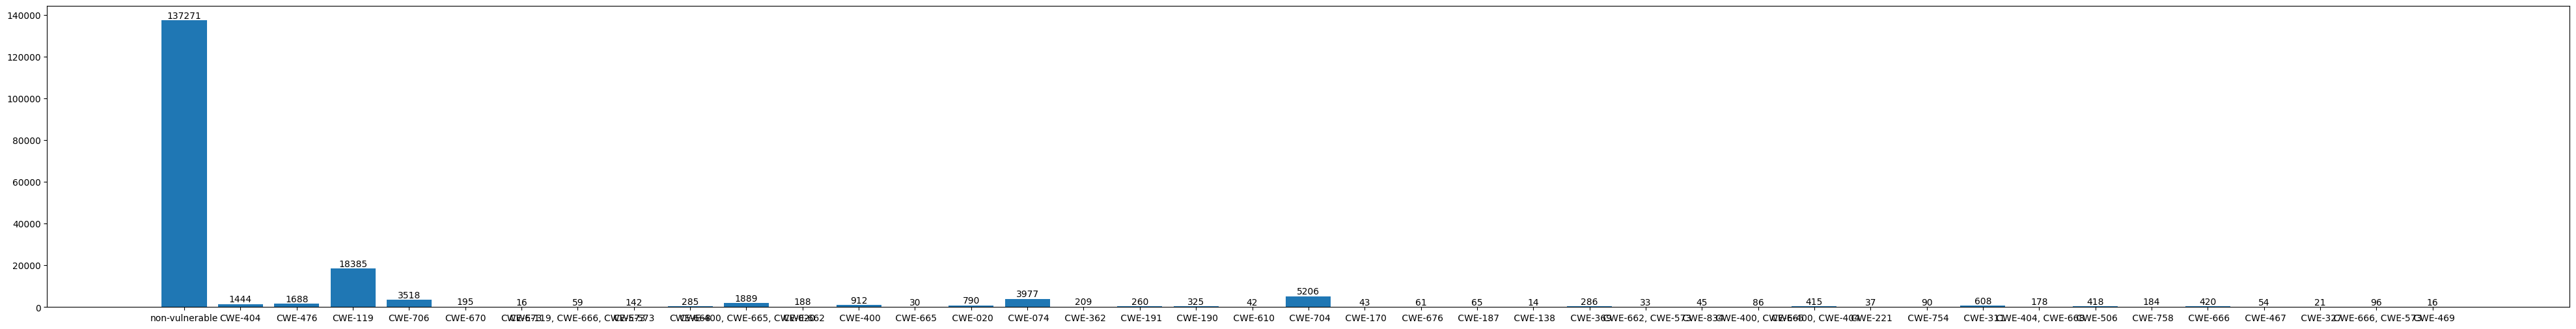

In [ ]:
x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))

# Plot the bar chart
bars = ax.bar(x_cwe, y_dataset, label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

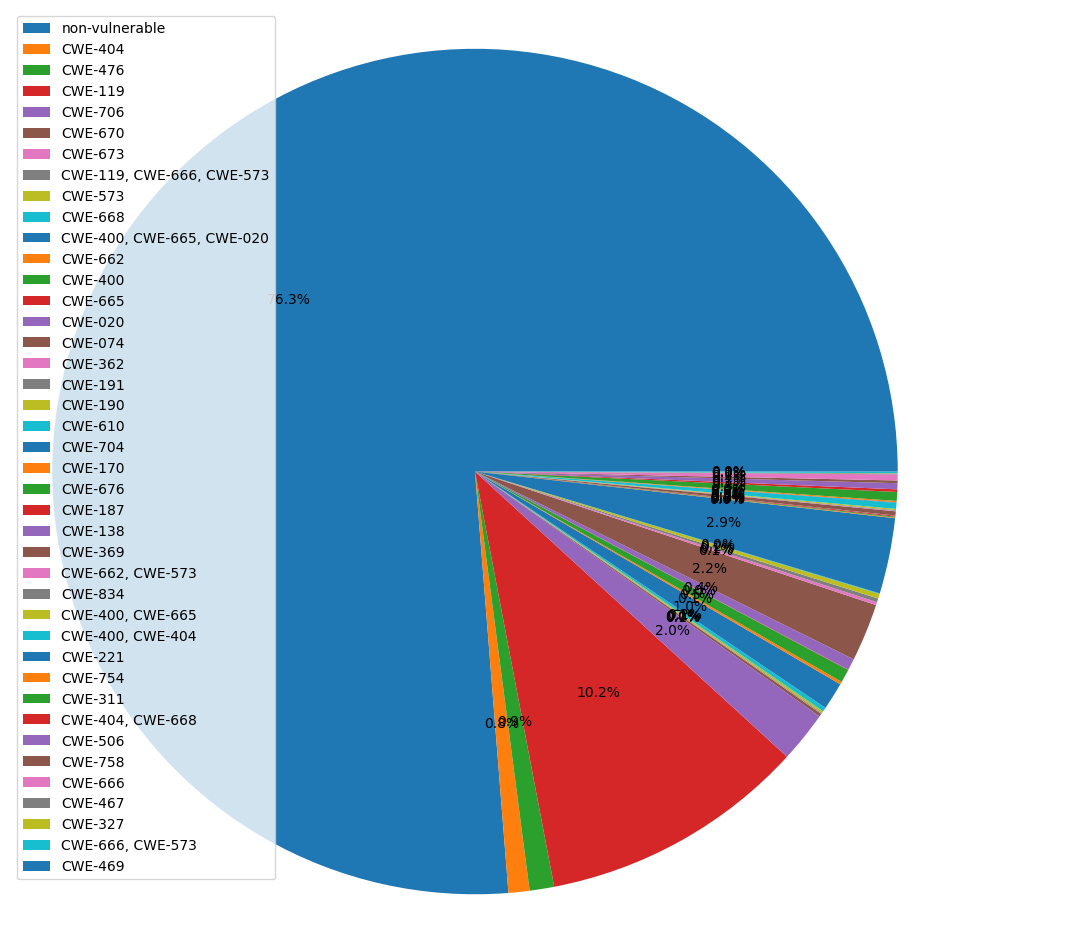

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data
x_cwe = ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
# Count occurrences of each CWE
cwe_counter = Counter(x_cwe)
cwe_values = list(cwe_counter.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(y_dataset, labels=cwe_counter.keys(), autopct='%1.1f%%', textprops=dict(color="w"))

# Add percentage annotations
for autotext in autotexts:
    autotext.set_color('black')

# Set the aspect ratio to be equal, ensuring the pie is drawn as a circle
ax.axis('equal')
plt.legend()

# Show the plot
plt.show()


# Data augmentation

In [ ]:
pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.char as nac

test_sentence = 'I went Shopping Today, and my trolly was filled with Bananas. I also had food at burgur palace'

aug = nac.KeyboardAug(name='Keyboard_Aug', aug_char_min=1, aug_char_max=10, aug_char_p=0.3, aug_word_p=0.3,
                      aug_word_min=1, aug_word_max=10, stopwords=None, tokenizer=None, reverse_tokenizer=None,
                      include_special_char=True, include_numeric=True, include_upper_case=True, lang='en', verbose=0,
                      stopwords_regex=None, model_path=None, min_char=4)

test_sentence_aug = aug.augment(test_sentence)
print(test_sentence_aug)

['I wFht Shopping Today, and my trolly was filled !lth BwHaGas. I xldo had fKoR at bufg6r palace']


In [ ]:
dataset_aug = dataset[:]
for i in range(1,41):
  temp = []
  for s in dataset[dataset['label'] == i]['1']:
    temp.append(s)
    temp.append(s)
  temp_aug = aug.augment(temp)
  temp_pandas = pd.DataFrame(temp_aug)
  temp_pandas.columns = ['1']
  temp_pandas['label'] = int(i)
  dataset_aug = pd.concat([dataset_aug, temp_pandas], axis=0, ignore_index=True)
print(dataset_aug.shape)

(265461, 2)


In [ ]:
len_dataset_aug = int(dataset_aug.shape[0])
y_dataset_aug = np.array([])
for i in range(41):
  number = int(dataset_aug[dataset_aug['label'] == i].shape[0])
  y_dataset_aug = np.insert(y_dataset_aug,len(y_dataset_aug),number)


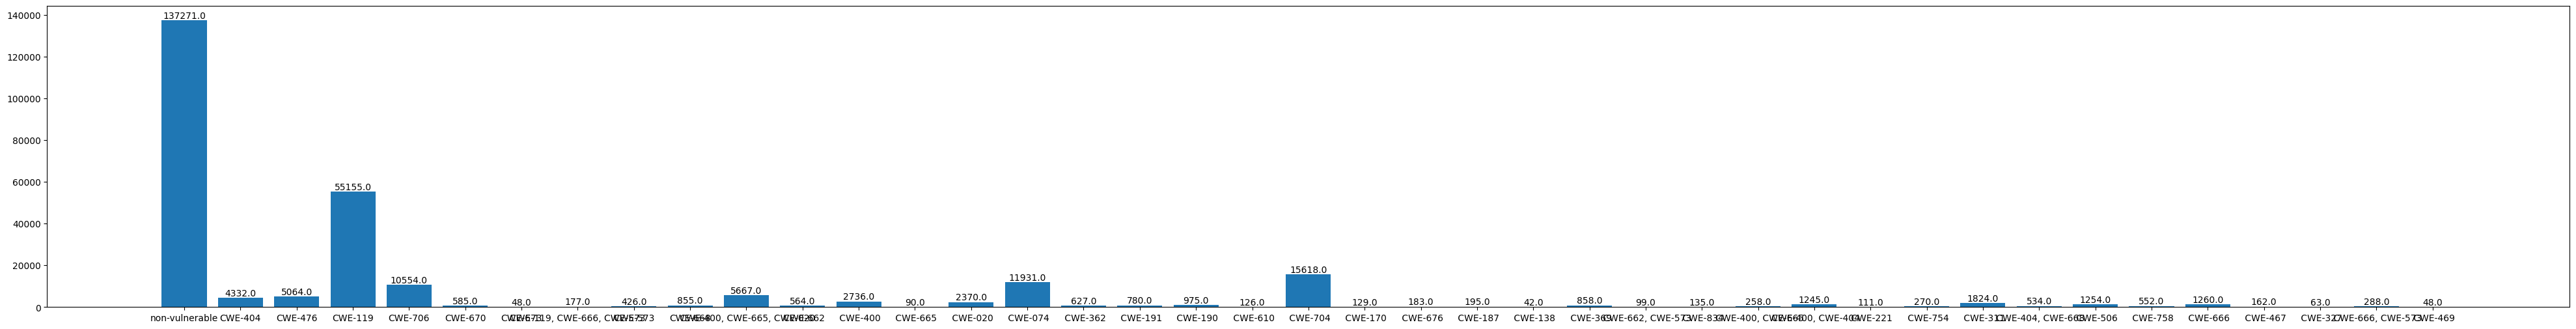

In [ ]:
x_cwe = ["non-vulnerable","CWE-404","CWE-476","CWE-119","CWE-706","CWE-670","CWE-673","CWE-119, CWE-666, CWE-573","CWE-573","CWE-668"," CWE-400, CWE-665, CWE-020",
         " CWE-662"," CWE-400"," CWE-665"," CWE-020", " CWE-074"," CWE-362"," CWE-191"," CWE-190"," CWE-610"," CWE-704"," CWE-170"," CWE-676"," CWE-187"," CWE-138",
         " CWE-369"," CWE-662, CWE-573"," CWE-834"," CWE-400, CWE-665"," CWE-400, CWE-404"," CWE-221", " CWE-754"," CWE-311"," CWE-404, CWE-668"," CWE-506"," CWE-758",
         " CWE-666"," CWE-467"," CWE-327"," CWE-666, CWE-573"," CWE-469"]

fig, ax = plt.subplots(figsize=(50, 6))

# Plot the bar chart
bars = ax.bar(x_cwe,y_dataset_aug , label='Some label')

# Add annotations for each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height}', ha='center', va='bottom')

# Show the plot
plt.show()

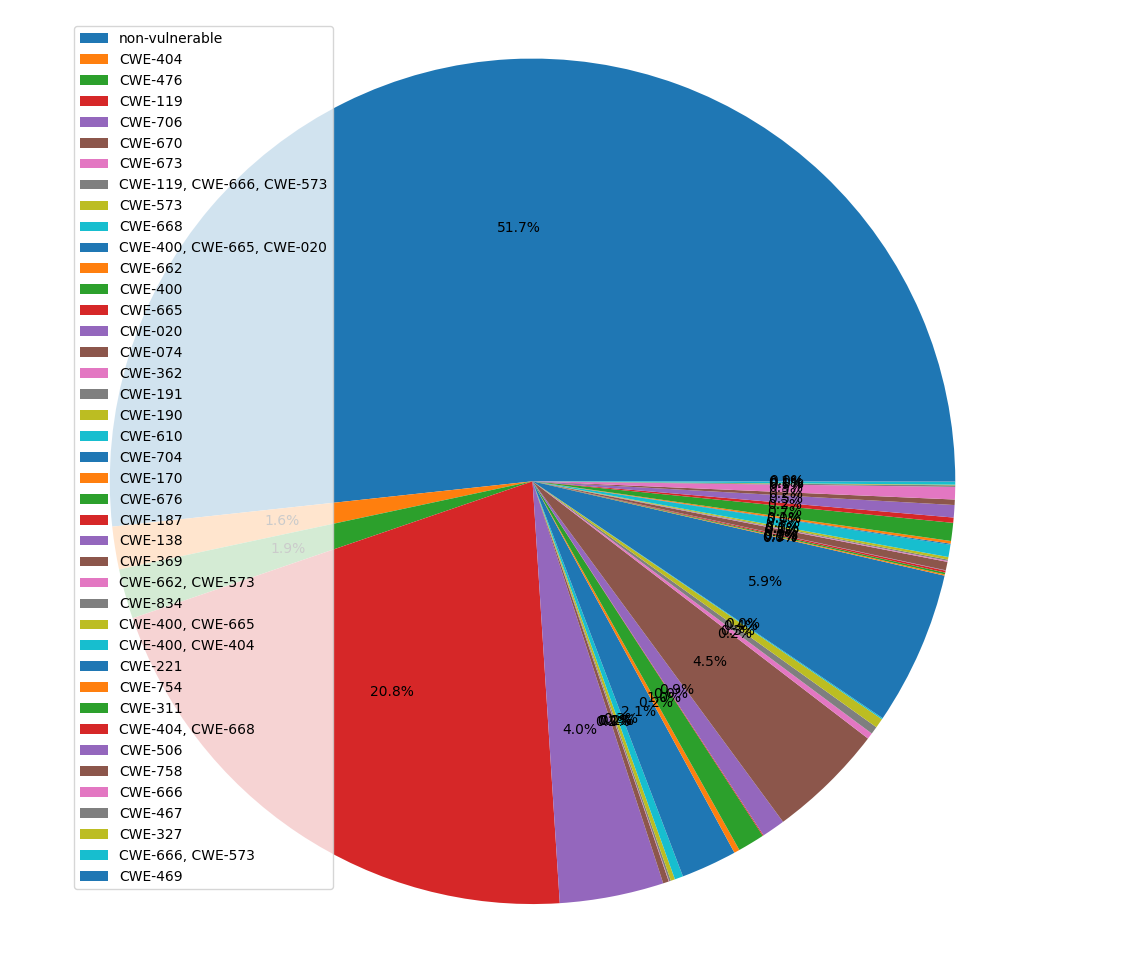

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Sample data
x_cwe = ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
# Count occurrences of each CWE
cwe_counter = Counter(x_cwe)
cwe_values = list(cwe_counter.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the pie chart
wedges, texts, autotexts = ax.pie(y_dataset_aug, labels=cwe_counter.keys(), autopct='%1.1f%%', textprops=dict(color="w"))

# Add percentage annotations
for autotext in autotexts:
    autotext.set_color('black')

# Set the aspect ratio to be equal, ensuring the pie is drawn as a circle
ax.axis('equal')
plt.legend()

# Show the plot
plt.show()


# Train Test split

In [ ]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.4


train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()
for i in range(41):
  len_dataset_aug_byCWE = int(dataset_aug[dataset_aug['label'] == i].shape[0])

  temp_train = dataset_aug[dataset_aug['label'] == i][:int(TRAIN_RATIO * len_dataset_aug_byCWE)]
  train_dataset = pd.concat([temp_train, train_dataset], axis=0, ignore_index=True)

  temp_test = dataset_aug[dataset_aug['label'] == i][int(TRAIN_RATIO * len_dataset_aug_byCWE) : int(len_dataset_aug_byCWE)]
  test_dataset = pd.concat([temp_test, test_dataset], axis=0, ignore_index=True)

print(train_dataset['label'].value_counts())
print(test_dataset['label'].value_counts())

0     82362
3     33093
20     9370
15     7158
4      6332
10     3400
2      3038
1      2599
12     1641
14     1422
32     1094
36      756
34      752
29      747
18      585
25      514
9       513
17      468
16      376
5       351
11      338
35      331
33      320
8       255
39      172
31      162
28      154
23      117
22      109
7       106
37       97
27       81
21       77
19       75
30       66
26       59
13       54
38       37
6        28
40       28
24       25
Name: label, dtype: int64
0     54909
3     22062
20     6248
15     4773
4      4222
10     2267
2      2026
1      1733
12     1095
14      948
32      730
36      504
34      502
29      498
18      390
25      344
9       342
17      312
16      251
5       234
11      226
35      221
33      214
8       171
39      116
31      108
28      104
23       78
22       74
7        71
37       65
27       54
21       52
19       51
30       45
26       40
13       36
38       26
6        20
40       20
24

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.sample(frac=1, replace=True, random_state=1)
test_dataset = test_dataset.sample(frac=1, replace=True, random_state=1)

In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

(159262, 2)
(106199, 2)


# Model preparation

In [ ]:
#<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>
text_data = train_dataset['1'].values
tensor = tf.data.Dataset.from_tensor_slices(text_data)

In [ ]:
tensor

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:

VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tensor)

In [ ]:
train_dataset['1']

128037    67129 111832/CWE690_NULL_Deref_From_Return__wc...
5192      17150 95268 / CWE369_Divide_by_Zero__int_liste...
50057     117403 75104/CWE124_Buffer_Underwrite__new_wch...
109259    42400 76164/CWE126_Buffer_Overread__char_decla...
73349     20313 111083 / CWE690_NULL_Deref_From_Return__...
                                ...                        
89740     16897 72945/CWE122_Heap_Based_Buffer_Overflow_...
123024    60545 150219/avdevice.c calloc 89\nunsigned in...
10997     1261 87497 / CWE195_Signed_to_Unsigned_Convers...
104183    35801 153297/dfa.c memcpy 2223\nstatic void bu...
81407     5951 99205/CWE401_Memory_Leak__char_calloc_05....
Name: 1, Length: 159262, dtype: object

In [ ]:
train_dataset

,1,label
128037,67129 111832/CWE690_NULL_Deref_From_Return__wc...,0
5192,17150 95268 / CWE369_Divide_by_Zero__int_liste...,25
50057,117403 75104/CWE124_Buffer_Underwrite__new_wch...,3
109259,42400 76164/CWE126_Buffer_Overread__char_decla...,0
73349,20313 111083 / CWE690_NULL_Deref_From_Return__...,2
...,...,...
89740,16897 72945/CWE122_Heap_Based_Buffer_Overflow_...,0
123024,60545 150219/avdevice.c calloc 89\nunsigned in...,0
10997,1261 87497 / CWE195_Signed_to_Unsigned_Convers...,20
104183,35801 153297/dfa.c memcpy 2223\nstatic void bu...,0


In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '0', 'if', 'data', '1', 'char', 'void', 'service',
       '100', 'i', 'd', 'int', 'sizeof', 's', 'recvresult', 'null', '2',
       'datalen', 'line'], dtype='<U559')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
X_train = train_dataset['1']
y_train = train_dataset['label']
y_train = tf.keras.utils.to_categorical(y_train, num_classes=41)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(159262,)
(159262, 41)


In [ ]:
history = model.fit(X_train,y_train, epochs=1,
                    # validation_data=test_dataset,
                    # validation_steps=30
                    )

4977/4977 [==============================] - 526s 103ms/step - loss: 0.5766 - accuracy: 0.8660


In [ ]:
X_test = test_dataset['1']
y_test = test_dataset['label']
y_test = tf.keras.utils.to_categorical(y_test, num_classes=41)

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

3319/3319 [==============================] - 103s 30ms/step - loss: 0.1331 - accuracy: 0.9726
Test Loss: 0.1331198662519455
Test Accuracy: 0.9726080298423767


In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred)
print(y_test.shape)
print(y_test)

3319/3319 [==============================] - 94s 27ms/step
(106199, 41)
[[9.93773580e-01 1.77842146e-03 3.41787348e-10 ... 4.72133277e-10
  4.11994624e-05 3.90930399e-09]
 [9.99709427e-01 2.28440200e-04 1.99462825e-11 ... 1.21763259e-11
  1.61101434e-06 1.07094195e-10]
 [1.27596970e-04 1.96791124e-02 6.01648344e-06 ... 2.62070259e-08
  1.33901442e-04 1.26460563e-07]
 ...
 [7.72660278e-05 2.29606219e-02 1.64994062e-03 ... 1.03751609e-06
  3.21511106e-05 4.36425402e-08]
 [6.25730641e-13 1.83790726e-05 8.07390024e-05 ... 2.52906091e-07
  1.07269322e-07 5.23346033e-10]
 [9.95697975e-01 3.68476583e-04 9.34995171e-07 ... 2.73741705e-07
  1.14802329e-04 5.95126403e-06]]
(106199, 41)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
max_y_test_indices = np.argmax(y_test, axis=1)
max_y_pred_indices = np.argmax(y_pred, axis=1)

array_sum     = [0] * 41
array_correct = [0] * 41

array_sum = np.array(array_sum)
array_correct = np.array(array_correct)



for i in range(len(max_y_test_indices)):
  if max_y_test_indices[i] == max_y_pred_indices[i]:
    array_correct[max_y_test_indices[i]] += 1
  array_sum[max_y_test_indices[i]] += 1

print(array_sum)
print(len(array_sum))
print(array_correct)
print(len(array_correct))


[54924  1678  2044 22289  4169   192    15    75   180   334  2220   228
  1094    33   937  4705   242   301   379    59  6300    47    74    75
    32   323    48    49   133   472    44    97   769   237   480   215
   490    58    22   114    22]
41
[54924  1639  2035 22283  4160     0     0     0     0   230  2189   218
   926     0   912  4666     0    96   208     0  6300     0     0     0
     0   240     0     0     0   355     0     0   755     0   477   200
   477     0     0     0     0]
41


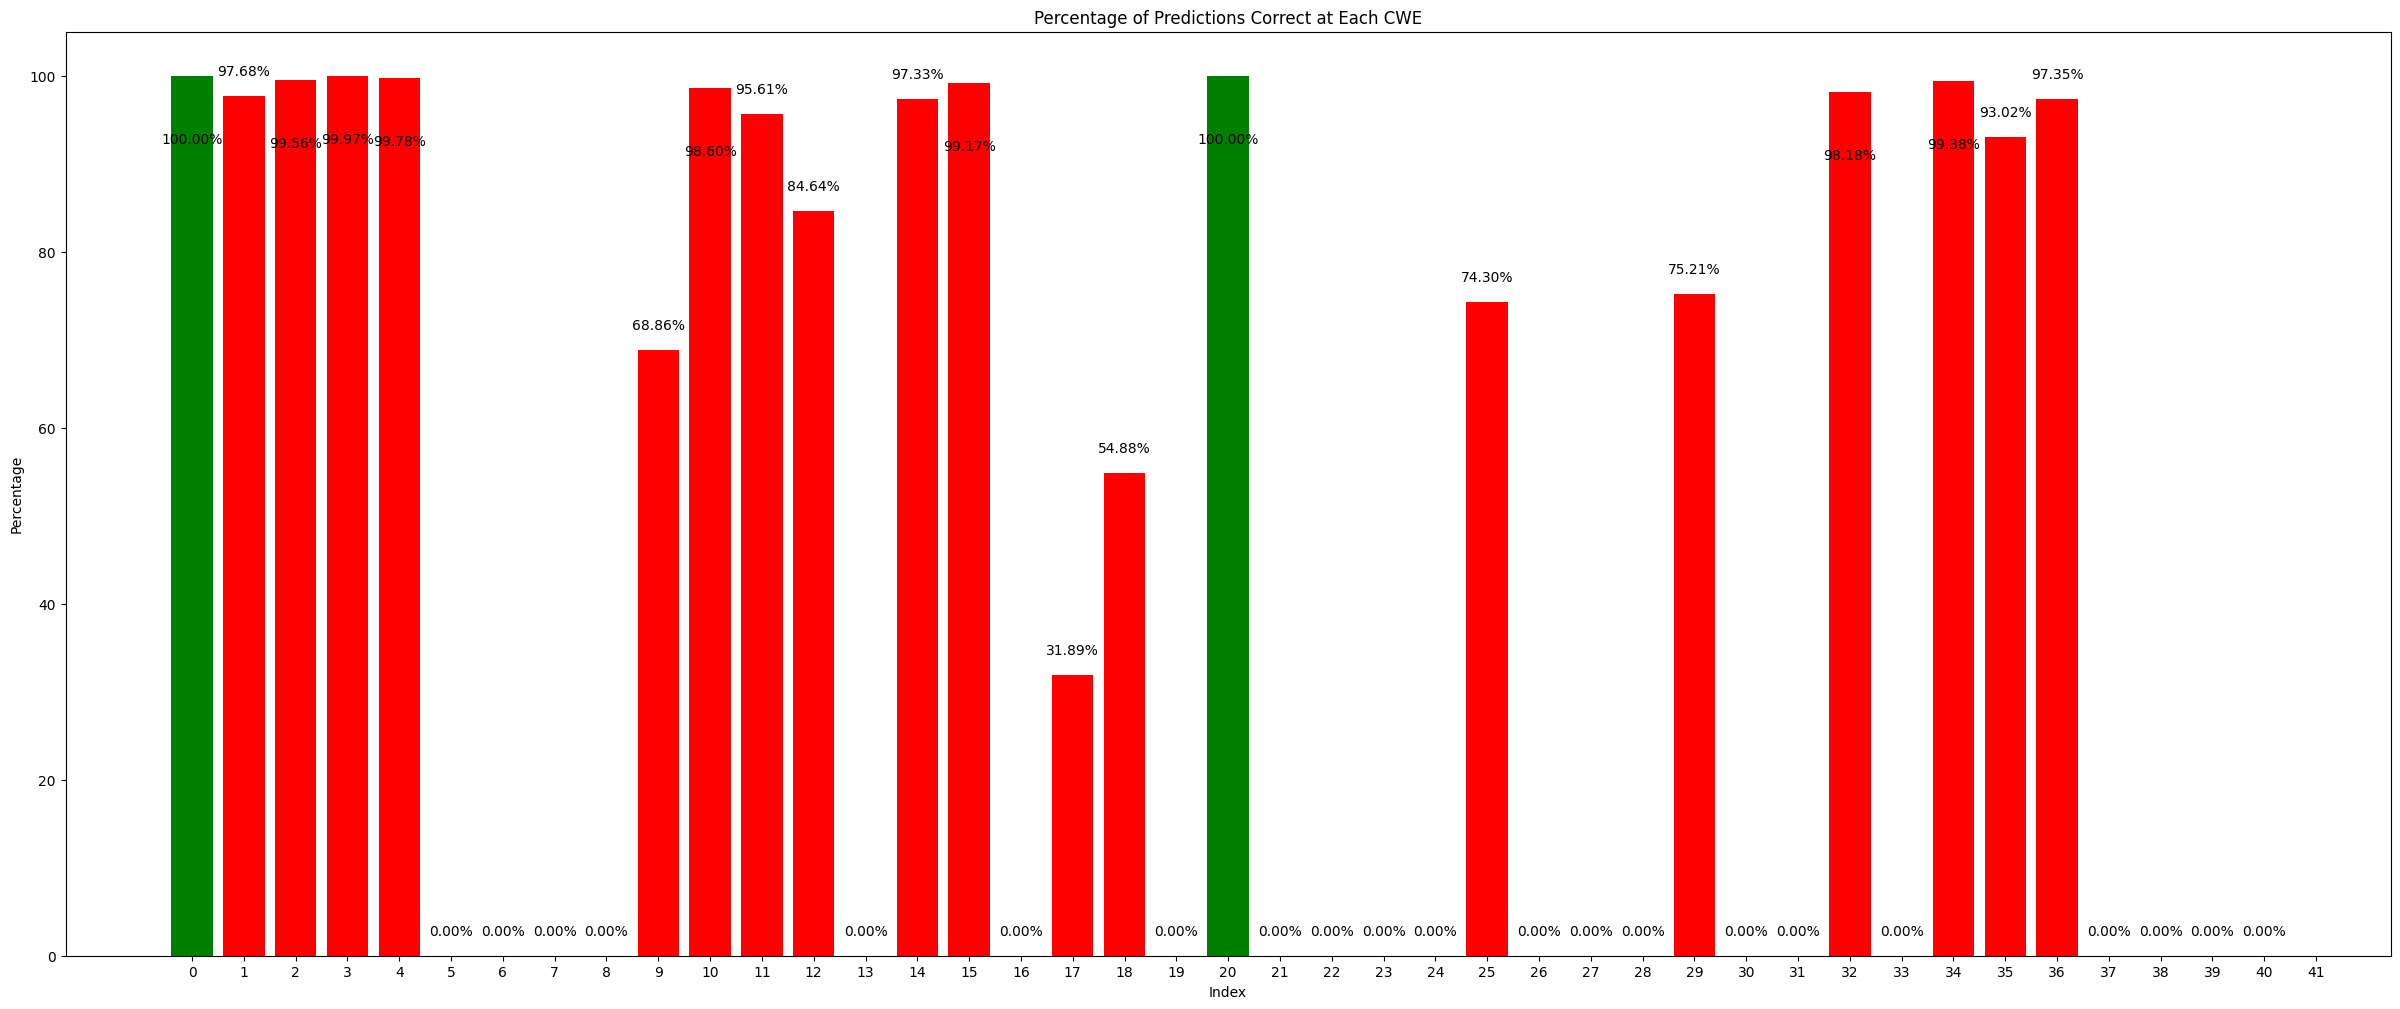

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = predictions * 100.0 / labels

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(30, 12))
ax.bar(range(len(labels)), percentages, color=['green' if p == 100 else 'red' for p in percentages])
ax.set_xlabel('Index')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each CWE')

ax.set_xticks(range(0, len(labels) + 1))

# Display the percentage on top of the bars with adjusted position
for i, v in enumerate(percentages):
    text_position = v + 2 if v < 98 else v - 8  # Adjust the position based on the value
    ax.text(i, text_position, f'{v:.2f}%', ha='center', va='bottom', color='black')

plt.show()


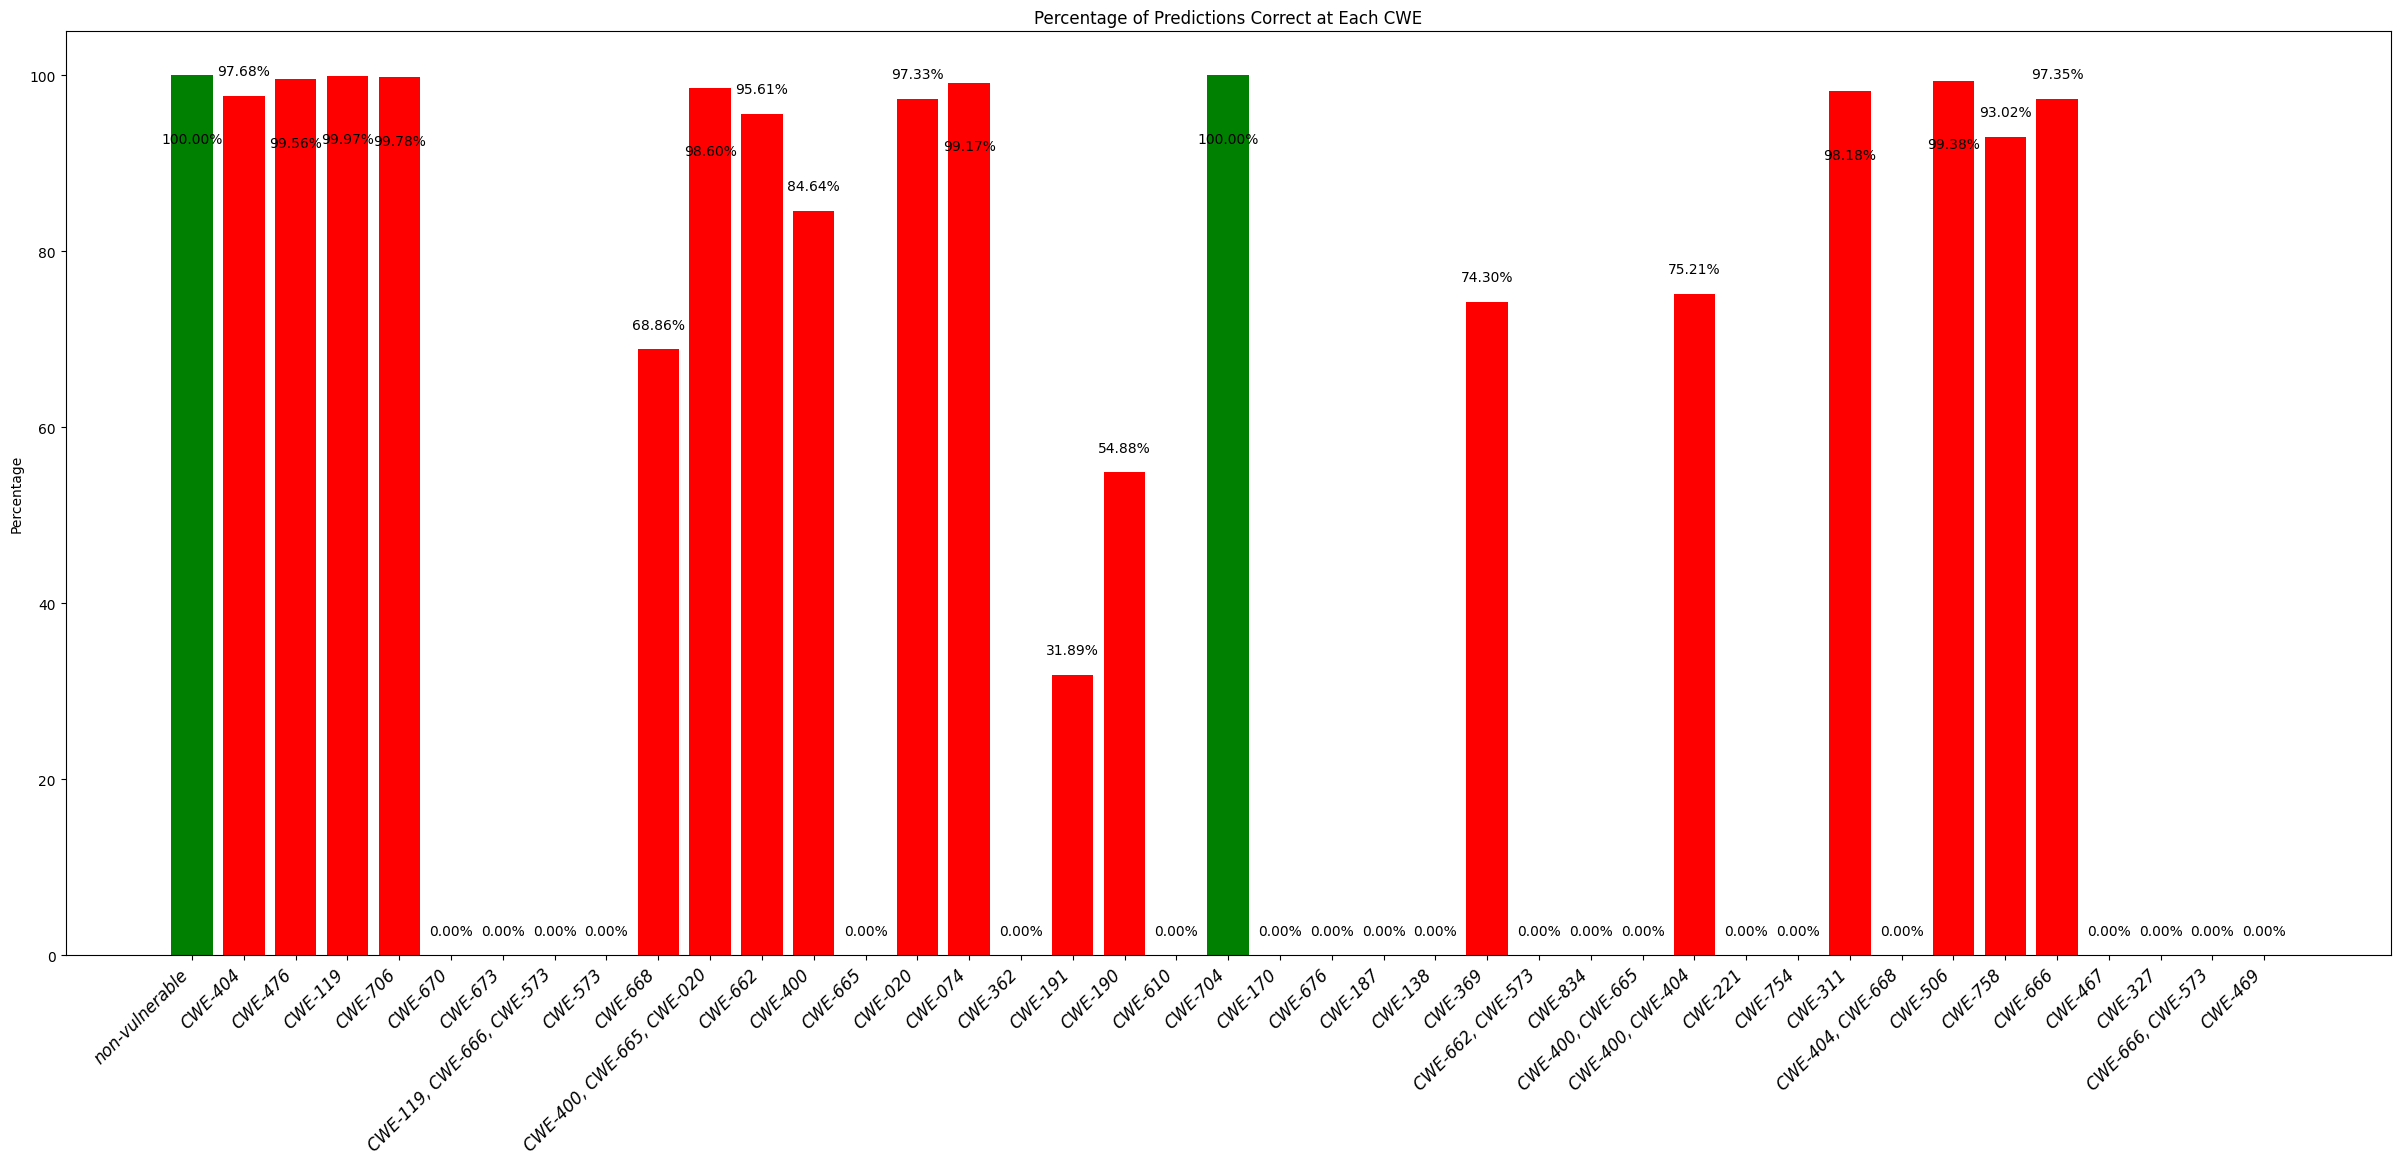

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
labels = array_sum
predictions = array_correct

# Calculate the percentage of correct predictions for each index
percentages = predictions * 100.0 / labels

# Create a bar chart for each index
fig, ax = plt.subplots(figsize=(30, 12))
ax.bar(range(1, len(labels) + 1), percentages, color=['green' if p == 100 else 'red' for p in percentages])

# Set x-ticks to display values from 1 to 40 with "CWE" prefix
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(
    ["non-vulnerable", "CWE-404", "CWE-476", "CWE-119", "CWE-706", "CWE-670", "CWE-673", "CWE-119, CWE-666, CWE-573",
         "CWE-573", "CWE-668", "CWE-400, CWE-665, CWE-020", "CWE-662", "CWE-400", "CWE-665", "CWE-020", "CWE-074", "CWE-362",
         "CWE-191", "CWE-190", "CWE-610", "CWE-704", "CWE-170", "CWE-676", "CWE-187", "CWE-138", "CWE-369", "CWE-662, CWE-573",
         "CWE-834", "CWE-400, CWE-665", "CWE-400, CWE-404", "CWE-221", "CWE-754", "CWE-311", "CWE-404, CWE-668", "CWE-506",
         "CWE-758", "CWE-666", "CWE-467", "CWE-327", "CWE-666, CWE-573", "CWE-469"]
    , rotation=45, ha='right', fontsize=12, fontstyle='italic')

ax.set_ylabel('Percentage')
ax.set_title('Percentage of Predictions Correct at Each CWE')

# Display the percentage on top of the bars with adjusted position
for i, v in enumerate(percentages):
    text_position = v + 2 if v < 98 else v - 8  # Adjust the position based on the value
    ax.text(i + 1, text_position, f'{v:.2f}%', ha='center', va='bottom', color='black')

plt.show()
